In [1]:
import math
import torch
from torch import nn
from torch import Tensor
from torch.nn  import functional as F
import gpytorch
from matplotlib import pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.cm as cm
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D 
import sys
from decimal import Decimal
from IPython.display import clear_output
sys.path.append("..")
from LBFGS import FullBatchLBFGS
from kernels import vvkernels as vvk, sep_vvkernels as svvk, vvk_rbfkernel as vvk_rbf
from means import vvmeans as vvm
from likelihood import vvlikelihood as vvll
from mlikelihoods import MarginalLogLikelihood as exmll
from predstrategies import GPprediction
from utils import ObjFun, get_vertices, stopping_criteria
from scipy import stats
import numpy as np
import seaborn as sns
import scipy
%matplotlib inline
%load_ext autoreload
%autoreload 2

# If model is bad, initialize at previous 2 sample!!!

In [2]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)    # fontsize of the tick labels
plt.rc('legend', fontsize=24)    # legend fontsize
plt.rc('font', size=24)          # controls default text sizes


# Objective function

We sample from $$V_1(x_1, x_2) = 3(1 - x_1)^2 e^{-x_1^2 - (x_2 +1)^2} - 10 (x_1/5 - x_1 ^3 - x_2^5) e^{-x_1^2 - x_2 ^2} - 3 e^{- (x_1 + 2) ^2 - x_2^2} + 0.5(2x_1 + x_2)$$
$$V_2(x_1, x_2) = 3(1 +x_2)^2 e^{-x_2^2 - (x_1 +1)^2} - 10 (-x_2/5 + x_2 ^3 + x_1^5) e^{-x_1^2 - x_2 ^2} - 3 e^{- ( 2- x_2) ^2 - x_1^2} + 0.5(2x_1 + x_2)$$

where $(x_1, x_2) \in [-3, 3]^2$

In [3]:
torch.set_default_dtype(torch.float64)

In [4]:
vf = ObjFun()
f_target = vf.tgt_vec
print(f_target)
sample_size = 4
D = vf.D
N = vf.N

vf.low = -3.
vf.high = 3.

high_minus_low = vf.high- vf.low
#high_minus_low = -
def g_theta(sample_size, D):
    loc_x = (2. - 1.0 )  * np.random.random_sample((sample_size,1)) + 1.0
    
    loc_y = (2.  -1.0)  * np.random.random_sample((sample_size,1)) - 2.
    loc = np.concatenate((loc_x, loc_y), 1)
    #loc = high_minus_low  * np.random.random_sample((sample_size,2)) + vf.low#(np.random.uniform(low=vf.low, high=vf.high, size=(sample_size, D)))
    return Tensor(loc)
train_x = g_theta(sample_size, D)
#train_x = Tensor([[-1.5, 1.5], [-1.5, 1.3]])
print(train_x)
noise_value = 0.0004 #noise_free = 0.
def vfield_(x):
    x = x.reshape(x.shape[0],D)
    out = torch.zeros(x.shape[0], N)
    
    out = vf(x[:,0], x[:,1]) + torch.randn(Tensor(vf(x[:,0], x[:,1])).size()) * math.sqrt(noise_value)
    return out #/torch.max(out)

train_y = vfield_(train_x)

# print(train_y)
# train_y = (train_y - train_y.mean())/train_y.std(dim=-2, keepdim=True)
# train_x = (train_x - train_x.mean())/train_x.std(dim=-2, keepdim=True)
# print(train_y)
# print(train_y.std(dim=-2, keepdim=True))



tensor([0.3380, 0.3502], dtype=torch.float32)
tensor([[ 1.4786, -1.5480],
        [ 1.1059, -1.5941],
        [ 1.5712, -1.8514],
        [ 1.5171, -1.3094]])


In [5]:
0.0779/ 0.0305


2.5540983606557375

## GP model initialization
We inialize the GP model following https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [6]:
x_train = train_x #loc #torch.linspace(0, 1, 10)
y_train = train_y #v  #torch.stack([torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,], -1)

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood,num_base_kernels):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        a = torch.ones(2,2)
        chol_q = torch.tril(a)
        self.mean_module = vvm.TensorProductSubMean(gpytorch.means.LinearMean(2), num_tasks = 2)  #vvm.TensorProductSubMean(gpytorch.means.LinearMean(2), num_tasks = 2)#vvm.TensorProductSubMean(gpytorch.means.ConstantMean(), num_tasks = 2)  # 
        base_kernels = []
        for i in range(num_base_kernels):
            base_kernels.append(gpytorch.kernels.ScaleKernel(( gpytorch.kernels.RBFKernel() ))) #gpytorch.kernels.PolynomialKernel(4)  ##gpytorch.kernels.MaternKernel()# (vvk_rbf.vvkRBFKernel())
 
            
        self.covar_module = svvk.SepTensorProductKernel(base_kernels,num_tasks = 2)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
    



# Hyperparamaters oprimization

In [7]:
# # ###hyperparameters optimization###
def hyper_opti(g_theta1, agg_data, training_iter,num_base_kernels,noise_value, current_model = None, current_likelihood = None):
    noises = torch.ones(agg_data.shape[0]) * (noise_value) #  torch.zeros(agg_data.shape[0]) # 
    noises = noises.reshape(g_theta1.shape[0], 2)
    
#     if (current_model is not None):
#         likelihood = current_likelihood #vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises) #vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises)  #

#         model = current_model#.get_fantasy_model(g_theta1, agg_data) #MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)
#         model.set_train_data(g_theta1, agg_data,  strict=False)
#     else:
#         likelihood = vvll.FixedNoiseMultitaskGaussianLikelihood(noises) #vvll.TensorProductLikelihood(num_tasks = 2)#vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises) #
#         model = MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)
        
    likelihood =  vvll.FixedNoiseMultitaskGaussianLikelihood(noises) #vvll.TensorProductLikelihood(num_tasks = 2) #
    model = MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)
    model.double()
    likelihood.double()


    model.train()
    
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(),  lr=0.1) #, weight_decay=0.001)  # Includes GaussianLikelihood parameters
    mll = exmll(likelihood, model)

    for i in range(training_iter):
        optimizer.zero_grad()

        loss, chi_square = mll(agg_data,g_theta1, model, likelihood, noise_value)
        loss = -1. * loss
#         print('df is %.3f' %agg_data.shape[0] +'and chi_square %.3f' %chi_square) 
        #print('loss is %.3f' %loss)
        df = agg_data.shape[0]
        chi_square = chi_square.clone().detach()
        
        p_val = 1. - stats.chi2.cdf(chi_square, df)
        loss.backward()
        optimizer.step()
        #scheduler.step(loss)
       # print(p_val)
#         if (p_val > 0.99999):
#             return model, likelihood


    
        
    print('loss is %.3f' %loss)
#     for params in model.named_parameters():
#         print(params)
    return model, likelihood

# Design parameters and sampling point optimization

In [8]:
# def conduct_design_opti(x0,loc_sample, f_target, g_theta1, agg_data, model, likelihood, training_design_iter, training_param_iter, lr_new,noise_value):
#     g_theta2 = nn.Parameter(Tensor(loc_sample))

#     x_d= nn.Parameter(Tensor(x0))
#     #optimizer = torch.optim.LBFGS(list([g_theta2,x_d]), lr= .000001, max_iter = 100,line_search_fn="strong_wolfe")  #
    
#     optimizer = FullBatchLBFGS(list([g_theta2,x_d]), lr=.001)
#     def closure():
#         optimizer.zero_grad()
        
#         loss2, pf1, Qf1, Qf12, data_fit, Q21 = likelihood.get_ell(agg_data,f_target,x_d, g_theta1, model, likelihood, noise_value, g_theta2)
        
#         loss2 = -1. * loss2

       

       
#         return loss2
        
#     loss2 = closure()
#     loss2.backward()
#     #fail = False
#     for i in range(training_design_iter):
#         options = {'closure': closure, 'current_loss': loss2, 'max_ls': 10}
#         loss2, _, _, _, _, _, _, fail = optimizer.step(options)
#         #print('design Iter %d/%d - Loss: %.3f' %(i + 1, training_design_iter, loss2.item()))
  
#         if fail:
#             print('Convergence reached!')

#             break
            
    
    

  
#     loss2, pf1, Qf1, Qf12, data_fit, Q21 = likelihood.get_ell(agg_data,f_target,x_d, g_theta1, model, likelihood, noise_value, g_theta2)
#     loss2 = -1. * loss2
#     print('Loss design: %.3f' % ( loss2))
#     #print(x_d)
#     return x_d, g_theta2, loss2, pf1, Qf1, Qf12, data_fit, Q21
    
    

In [9]:
def conduct_design_opti(x0,loc_sample, f_target, g_theta1, agg_data, model, likelihood, training_design_iter, training_param_iter, lr_new,noise_value):

    g_theta2 = nn.Parameter(Tensor(loc_sample))

    x_d= nn.Parameter(Tensor(x0))
    
    optimizer = torch.optim.Adam([{'params': g_theta2, 'lr': 0.1},{'params': x_d, 'lr': 0.1}])

    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    for ii in range( training_param_iter ):
#         x_d = torch.cat([x_d_0, x_d_1]).reshape(1,2)
#         g_theta2 = torch.cat([g_theta20, g_theta21],1)
        optimizer.zero_grad()
        loss2, pf1, Qf1, Qf12, data_fit, Q21 = likelihood.get_ell(agg_data,f_target,x_d, g_theta1, model, likelihood, noise_value, g_theta2)

        loss2 = -1. * loss2
        
        loss2.backward()
        
        optimizer.step()
        
    loss2, pf1, Qf1, Qf12, data_fit, Q21 = likelihood.get_ell(agg_data,f_target,x_d, g_theta1, model, likelihood, noise_value, g_theta2)
    loss2 = -1. * loss2
    print('Loss design: %.3f' % ( loss2))
    #print(x_d)
    return x_d, g_theta2, loss2, pf1, Qf1, Qf12, data_fit, Q21
    
    

In [10]:
# from functools import partial
# def conduct_design_opti(x0,loc_sample, f_target, g_theta1, agg_data, model, likelihood, training_design_iter, training_param_iter, lr_new,noise_value):
    
#     fun = partial(likelihood.get_ell, agg_data,f_target, g_theta1, model, likelihood, noise_value)
#     def tad_obj(samples):
#         loss2, pf1, Qf1, Qf12, data_fit, Q21 = fun(samples)
#         return -loss2.detach().numpy()
    
    
#     sample0 = torch.cat([x0, loc_sample], 0)
#     print(sample0)
#     #print(sample0.shape)
#     res = scipy.optimize.minimize(tad_obj, sample0)#, method='nelder-mead')
#     sample_opt = res.x
#     loss2, pf1, Qf1, Qf12, data_fit, Q21 = fun(sample_opt)
#     loss2 = -1. * loss2
#     print('Loss design: %.3f' % ( loss2))

#     x_d = sample_opt[0:g_theta1.shape[1]]
#     x_d = Tensor(x_d.reshape(math.ceil(x_d.shape[0]/g_theta1.shape[1]), g_theta1.shape[1]))
#     g_theta2 = sample_opt[g_theta1.shape[1]:]
#     g_theta2 = Tensor(g_theta2.reshape(math.ceil(g_theta2.shape[0]/g_theta1.shape[1]), g_theta1.shape[1]))
#     return x_d, g_theta2, loss2, pf1, Qf1, Qf12, data_fit, Q21

# Conducting the TAD experiment

In [11]:
loc_size = 2
#loc_sample0 = Tensor((2. - 1.5)  * np.random.random_sample((loc_size,2)) + 1.5)
x0 = Tensor(np.array([-2. , -2.]))
 # 1./3. * Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
x0 = x0.reshape(1,2)

dis_2sample = MultivariateNormal( loc = x0, covariance_matrix= .01 * torch.eye(loc_size) )
                    #loc_size = 4
loc_sample = dis_2sample.sample((loc_size + 1,))

loc_sample0 = loc_sample.reshape(loc_size + 1, 2)
#loc_sample0[-1] = train_x[-1] + 0.01



In [12]:
loc_sample = loc_sample0.clone()
iter_hp = 50
iter_design = 100
iter_param = 100
num_base_kernels = 2
max_iter = 50


f_target = Tensor([[-1., -1.]]).reshape(2,1) 
tol_vector = 0.01 * torch.ones(f_target.shape)

plot_freq = 1


 #np.random.random_sample((loc_size,2))
#loc_sample = (loc_sample - loc_sample.mean())/loc_sample.std(dim=-2, keepdim=True)
#train_x = (train_x - train_x.mean())/train_x.std(dim=-2, keepdim=True)

#loc_sample = Tensor([[0.0, 0.1], [0.0, -0.1]]) #T
# loc_x = (-1.5 + 2.)  * np.random.random_sample((loc_size,1)) +2.

# # loc_y = (2. - 1.5)  * np.random.random_sample((loc_size,1)) - 1.5
# # loc = np.concatenate((loc_x, loc_y), 1)
print(loc_sample)


g_theta2_vec = (Tensor(loc_sample).clone()).flatten()

data_fit_vec = torch.empty((1,1))
entropy_vec = torch.empty((1,1))




#
vec_x = x0.clone() #Tensor(np.array([0.0,0.0])) 
vec_x = vec_x.reshape(1,2)
var_vec = torch.zeros([max_iter, 1])
p21_vec = torch.empty((1,1))

lr_new = .01
thresh_EI = 0.001
    
count_EI = 0
max_count_EI = 50

SUCCESS = False 
FAILURE = False 
show_TTRBox = False
iter = 0    
g_theta1 = x_train
agg_data = y_train.flatten()
patience = 0.0
patience_f = 0.0
patience_2 = 0.0
checking_model = False
model_double_check = False
while(SUCCESS == False and FAILURE == False):
    print(iter)
    model_double_check = False
    if (checking_model == False):
        print('START HYPERPARAMETERS optimization')
        if (iter == 0):
            cur_model = None
            cur_likelihood = None


        loc_sample_old = loc_sample.clone()
        x0_old = x0.clone()
        model, likelihood = hyper_opti(g_theta1,agg_data,iter_hp,num_base_kernels,noise_value, current_model = cur_model, current_likelihood = cur_likelihood)


        print('END HYPERPARAMETERS optimization')
    
    model.eval()
    likelihood.eval()
   
    
    x0_new,g_theta2, loss, pf1, Qf1, Qf12, data_fit, Q21 = conduct_design_opti(x0, loc_sample, f_target, g_theta1, agg_data, model, likelihood, iter_design,iter_param, lr_new,noise_value)
  
    cur_model = model
    cur_likelihood = likelihood
    
  
    lower_bound = torch.zeros(pf1.shape)
    upper_bound = torch.zeros(pf1.shape)
        
    for i in range(pf1.shape[0]):
        lower_bound[i] = pf1[i] -  torch.sqrt(Qf12[i,i])
        upper_bound[i] = pf1[i] +  torch.sqrt(Qf12[i,i])
#     d = torch.sqrt(gpytorch.inv_quad(Qf1, f_target - pf1))
#     print(d)
    SUCCESS = stopping_criteria(tol_vector, f_target, lower_bound, upper_bound)
    
    
    entropy = ( 0.5 * torch.log( torch.det(Qf1.evaluate()) / torch.det(Qf12.evaluate()) ) ).reshape(1,1)
    
    print('expected info is '+str(entropy))
    print('mohabb disatance is' + str(Qf12.inv_quad(f_target - pf1)))
    if not SUCCESS:
    
    #var_vec[iter] = var
        
        

         #np.random.random_sample((loc_size,2))

        

        new_data = vfield_(g_theta2.detach())  
        agg_data12 = torch.cat([agg_data, new_data.flatten()], 0)
        g_theta12= torch.cat([g_theta1, g_theta2.detach()], 0)
        new_data_x = vfield_(x0_new.detach() )  
        print('current sol is'+str(x0_new.detach()))
        print('new data is' + str(new_data_x))
        print('g_theta2 is' + str(g_theta2.detach()))
        
        
        
        

        
        with torch.no_grad():

            
            if iter >= 0:
                
                
                p21 = likelihood.get_p21(g_theta1, g_theta2.detach(), agg_data, model, noise_value)
                
#                 Q21 = Q21 + noise_value*torch.eye(Q21.shape[0])
                chi_21 = (Q21).inv_quad(new_data.flatten() - p21.reshape(new_data.flatten().shape))
                p_val = 1. - stats.chi2.cdf(chi_21, Q21.shape[0])
                pf12 = likelihood.get_pf12(Q21,g_theta1, g_theta2.detach(), x0_new.detach(), new_data.flatten(), pf1, p21, model, noise_value)
               
                #Qf12 = Qf12 + 
                chi_f12 = (Qf12 + noise_value*torch.eye(Qf12.shape[0])).inv_quad(new_data_x.flatten() - pf12.reshape(new_data_x.flatten().shape))
                p_val_f12 = 1. - stats.chi2.cdf(chi_f12, Qf12.shape[0])
                print('p21val is %.15f' %p_val)
                p21_vec = torch.cat([p21_vec, Tensor([p_val]).reshape(1,1)], 0)
                print('pf12val is %.15f' %p_val_f12)
                print('chi_f12 is %.15f' %chi_f12 )
                
                if (p_val < 0.01):# or p_val_f12 < 0.001:
                    model_double_check = True
                    checking_model = True
                    patience = patience+1
                    print('patience is %.3f' %patience)

                if (model_double_check == True):
                    #loc_sample = Tensor(high_minus_low  * np.random.random_sample((loc_sample.shape[0],2)) + vf.low)
                    sum = torch.zeros(2, 2) #replace with num_tasks
                    mean_2 = torch.mean(g_theta2.detach(), 0, True)
                    for i in range(loc_size):
                        #sum =sum + torch.matmul((g_theta2.detach()[i] -mean_2).t(), ( g_theta2.detach()[i] - mean_2 ) )# sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) #sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) # 
                        sum =sum + torch.matmul((g_theta2.detach()[i] -x0_old).t(), (g_theta2.detach()[i] - x0_old) ) #sum + torch.matmul((g_theta2.detach()[i] -
                    emp_cov = 1./loc_size * sum #+ torch.eye(sum.shape[0]) * 1e-8

                    dis_2sample = MultivariateNormal( loc = x0_old, covariance_matrix=emp_cov )
                    #loc_size = 4
                    loc_sample = dis_2sample.sample((loc_size,))

                    loc_sample = loc_sample.reshape(loc_size, 2)
                    loc_sample = torch.cat([loc_sample, x0_old],0)
                    
                    x0 = x0_old #Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low)
                    if (patience >= 2):# or patience_2 >= 2 or patience_f >= 2):
                        PATH = ".//model_Carlo/model_update/model_fail_EIbehavior_"+str(iter)+".pt"
                        torch.save(model, PATH)
                        entropy_vec = torch.cat([entropy_vec, entropy], 0)
                        data_fit_vec = torch.cat([data_fit_vec, data_fit], 0)
                        iter = iter + 1
                        patience = 0
#                         patience_2 = 0
#                         patience_f = 0
                        model_double_check = False
                        checking_model = False
                        num_base_kernels = num_base_kernels + 1
                        print('adding complexity to model')
                        print('num base is' + str(num_base_kernels))
#     #                         
                        loc_sample = loc_sample_old
                        #x0 = x0_old
                        agg_data = agg_data12.clone()
                        g_theta1 = g_theta12.clone()
                        vec_x = torch.cat([vec_x, x0_new.detach()])
                        g_theta2_vec = torch.cat([g_theta2_vec, g_theta2.detach().flatten()], 0)
                        print('acquiring, new size is' + str(g_theta1.shape[0]))
                 
                    #iter_hp = iter_hp + 10
                    
                    
                
                
                else:
                    PATH = ".//model_Carlo/model_goodmodel/model_fail_EIbehavior_"+str(iter)+".pt"
                    torch.save(model, PATH)
                    vec_x = torch.cat([vec_x, x0_new.detach()])
                    g_theta2_vec = torch.cat([g_theta2_vec, g_theta2.detach().flatten()], 0)
                    entropy_vec = torch.cat([entropy_vec, entropy], 0)
                    data_fit_vec = torch.cat([data_fit_vec, data_fit], 0)
                    model_double_check = False
                    iter = iter + 1
                    patience = 0
                    patience_2 = 0
                    patience_f = 0
                    checking_model = False
                    if (entropy < thresh_EI):
                        count_EI = count_EI + 1
                    else:
                        count_EI = 0
                    if (count_EI >= max_count_EI):
                        FAILURE = True
                    
                    x0 = (x0_new.detach())# + torch.randn(x0_new.detach().size()) * .001)#/torch.norm(x0_new.detach())
                    sum = torch.zeros(2, 2)
                    mean_2 = torch.mean(g_theta2.detach(), 0, True)

                    for i in range(loc_size):
                        #sum =sum + torch.matmul((g_theta2.detach()[i] -mean_2).t(), ( g_theta2.detach()[i] - mean_2 ) )# sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) #sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) # 
                        sum =sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) #sum + torch.matmul((g_theta2.detach()[i] -
                    emp_cov = 1./loc_size * sum# + torch.eye(sum.shape[0]) * 1e-8

                    dis_2sample = MultivariateNormal( loc = x0_new.detach(), covariance_matrix=emp_cov )
                    #loc_size = 4
                    loc_sample = dis_2sample.sample((loc_size,))

                    loc_sample = loc_sample.reshape(loc_size, 2)
                    #loc_sample = loc_sample#/torch.norm(loc_sample)
                    #loc_sample = 2. *  (loc_sample - torch.min(loc_sample)) / (torch.max(loc_sample) - torch.min(loc_sample)) - 1.
                    #loc_sample[0] = x0_new.detach() #+ torch.randn(x0_new.detach().size()) * .001 #g_theta2.detach() #loc_sample.reshape(loc_size, 2)
                    #loc_sample = Tensor(high_minus_low  * np.random.random_sample((loc_size,2)) + vf.low)
                    loc_sample = torch.cat([loc_sample, x0_new.detach()],0)
                    for i in range(loc_sample.shape[0]):
                        if loc_sample[i,0] < -3. or loc_sample[i,0] > 3. or loc_sample[i,1] < -3. or loc_sample[i,1] > 3.:
                            print('samples escaped box')
                            loc_sample[i] = Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low)
                    
                    
#                     if p_val > 0.99 and p_val_f12 > 0.99:
#                         num_base_kernels = max(num_base_kernels - 1, 3)
                        #iter_hp = iter_hp - 10
                    chi_f_target = (Qf12 ).inv_quad(f_target - pf1)
                    p_val_f_target = 1. - stats.chi2.cdf(chi_f_target, Qf12.shape[0])
                    print('p_val_ftarget is '+str(p_val_f_target))
                    if (p_val_f_target > .95):
                        print('acquiring target point becuse p_val_ftarget is '+str(p_val_f_target))
                        agg_data = agg_data12.clone()
                        g_theta1 = g_theta12.clone()
        

                        x0 = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
                        loc_sample[-1] = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
                        agg_data = torch.cat([agg_data12, new_data_x.flatten()], 0)
                        g_theta1= torch.cat([g_theta12, x0_new.detach()], 0)
                    else:
#                         x0 = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
#                         loc_sample[-1] = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
#                         agg_data = torch.cat([agg_data12, new_data_x.flatten()], 0)
#                         g_theta1= torch.cat([g_theta12, x0_new.detach()], 0)
                       
                        agg_data = agg_data12.clone()
                        g_theta1 = g_theta12.clone()
                        x0 = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
                        loc_sample[-1] = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
                        agg_data = torch.cat([agg_data12, new_data_x.flatten()], 0)
                        g_theta1= torch.cat([g_theta12, x0_new.detach()], 0)
                        
                    if x0_new.detach()[0,0] < -3. or x0_new.detach()[0,0] > 3. or x0_new.detach()[0,1] < -3. or x0_new.detach()[0,1] > 3.:
#                         x0 = Tensor(np.array([0.0,-1.0])) # 1./3. * Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
#                         x0 = x0.reshape(1,2) 
                        x0 = Tensor(np.array([-2. , 2.]))
 # 1./3. * Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
                        x0 = x0.reshape(1,2)
                        #x0 = Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
                 
             #       loc_sample = (loc_sample - loc_sample.mean())/loc_sample.std(dim=-2, keepdim=True)
                        loc_sample[-1] = x0 #(x0_new.detach()) 
                    print('new 2 points')
                    print(loc_sample)
                  
 #                    agg_data  = (agg_data  - agg_data.mean())/agg_data .std(dim=-1, keepdim=True)
#                     g_theta1 = (g_theta1 - g_theta1.mean())/g_theta1.std(dim=-2, keepdim=True)
        
        
                    
                    
                    
                
            
            #clear_output(wait=False)
           
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        

        
        

            
            
            
        
vec_x = torch.cat([vec_x, x0_new.detach()])
g_theta2_vec = torch.cat([g_theta2_vec, g_theta2.detach().flatten()], 0)
entropy_vec = torch.cat([entropy_vec, entropy], 0)
data_fit_vec = torch.cat([data_fit_vec, data_fit], 0)
PATH = ".//model_Carlo/model_goodmodel/model_fail_EIbehavior_"+str(iter)+".pt"
torch.save(model, PATH)
print('current sol is'+str(x0_new.detach()))
    
print('Success is ' + str(SUCCESS) + ' and failure is ' + str(FAILURE)+' after '+ str(iter) + ' iterations')

    

tensor([[-2.0176, -1.9085],
        [-1.9332, -1.9532],
        [-2.0003, -2.0948]])
0
START HYPERPARAMETERS optimization
loss is -3.296
END HYPERPARAMETERS optimization
Loss design: 274.919
expected info is tensor([[0.0081]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(561.7333, grad_fn=<SumBackward1>)
current sol istensor([[-0.1351,  1.2227]])
new data istensor([[ 0.7464, -0.4377]])
g_theta2 istensor([[ 0.2131, -2.9562],
        [ 0.2086, -2.9422],
        [ 0.0477, -2.8481]])
p21val is 0.000000000000000
pf12val is 0.000000000000000
chi_f12 is 1417.541401066284152
patience is 1.000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
0
Loss design: 374.193
expected info is tensor([[0.2779]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(760.2161, grad_fn=<SumBackward1>)
current sol istensor([[-0.0626,  1.2176]])
new data istensor([[ 0.7486, -0.4676]])
g_theta2 istensor([[-0.0120, -2.6505],
        [-2.6764,  2.3987],
  

loss is -1.981
END HYPERPARAMETERS optimization
Loss design: 195.293
expected info is tensor([[0.0074]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(394.6256, grad_fn=<SumBackward1>)
current sol istensor([[-3.0045,  0.1358]])
new data istensor([[-0.4569,  0.0296]])
g_theta2 istensor([[-1.8821, -0.5076],
        [-1.7443,  1.4505],
        [-1.8836, -0.4993]])
p21val is 0.797722878721942
pf12val is 0.322553033046070
chi_f12 is 2.262975425423926
samples escaped box
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[-2.6783, -0.3970],
        [-2.8203, -2.2761],
        [-2.0000,  2.0000]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
11
START HYPERPARAMETERS optimization
loss is -2.033
END HYPERPARAMETERS optimization
Loss design: 1059.865
expected info is tensor([[0.0081]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(2130.5938, grad_fn=<SumBackward1>)
current sol istensor([[-2.4220,  1.8467]])
new dat

loss is -2.120
END HYPERPARAMETERS optimization
Loss design: 1966.700
expected info is tensor([[7.5216e-05]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(3945.5583, grad_fn=<SumBackward1>)
current sol istensor([[-1.8843,  1.8933]])
new data istensor([[-0.0832, -0.0449]])
g_theta2 istensor([[ 1.3376,  1.3395],
        [ 2.3218, -1.4787],
        [-2.9000,  2.9427]])
p21val is 0.931383634247844
pf12val is 0.290818772970577
chi_f12 is 2.470109958222940
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[ 0.2868,  1.3812],
        [-2.8962,  2.8336],
        [-1.8848,  1.8931]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
22
START HYPERPARAMETERS optimization
loss is -2.151
END HYPERPARAMETERS optimization
Loss design: 838.934
expected info is tensor([[0.0002]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(1688.2731, grad_fn=<SumBackward1>)
current sol istensor([[-1.1956,  1.1354]])
new data istensor([[-0

Loss design: 1093.526
expected info is tensor([[0.0014]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(2036.0180, grad_fn=<SumBackward1>)
current sol istensor([[-3.0285,  2.2511]])
new data istensor([[-0.1999, -0.0238]])
g_theta2 istensor([[-2.1680,  0.3445],
        [-2.1827,  2.8202],
        [-1.2247,  2.8881]])
p21val is 0.983599137546626
pf12val is 0.788458724148978
chi_f12 is 0.475350442511035
samples escaped box
samples escaped box
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[ 1.6391, -1.8455],
        [-2.9509, -1.0188],
        [-2.0000,  2.0000]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
31
START HYPERPARAMETERS optimization
loss is -2.319
END HYPERPARAMETERS optimization
Loss design: 842.522
expected info is tensor([[0.0008]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(1623.0362, grad_fn=<SumBackward1>)
current sol istensor([[-3.0191,  0.6892]])
new data istensor([[-3.4008e-01, -

loss is -2.499
END HYPERPARAMETERS optimization
Loss design: 1545.642
expected info is tensor([[0.0010]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(2912.1255, grad_fn=<SumBackward1>)
current sol istensor([[-3.0310, -0.1861]])
new data istensor([[-0.4606,  0.0184]])
g_theta2 istensor([[-0.2550,  2.4621],
        [-2.0355, -1.2216],
        [-0.5711,  2.1080]])
p21val is 0.374887109928747
pf12val is 0.518496064912617
chi_f12 is 1.313645681418997
samples escaped box
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[-0.4080,  0.8760],
        [-1.5072, -2.9625],
        [-2.0000,  2.0000]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
42
START HYPERPARAMETERS optimization
loss is -2.513
END HYPERPARAMETERS optimization
Loss design: 4044.972
expected info is tensor([[2.2656e-05]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(8104.4473, grad_fn=<SumBackward1>)
current sol istensor([[-2.7042,  1.7683]])
n

loss is -2.597
END HYPERPARAMETERS optimization
Loss design: 406.472
expected info is tensor([[1.1177e-05]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(823.1789, grad_fn=<SumBackward1>)
current sol istensor([[-0.2731, -2.1063]])
new data istensor([[-0.5077,  0.1253]])
g_theta2 istensor([[-2.4971, -2.5019],
        [ 2.5340, -0.5569],
        [-2.2489, -2.4373]])
p21val is 0.723969144454867
pf12val is 0.840153196979680
chi_f12 is 0.348342052833489
p_val_ftarget is 0.0
new 2 points
tensor([[ 1.6856, -1.7800],
        [-0.5631, -1.9037],
        [-0.2724, -2.1071]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
53
START HYPERPARAMETERS optimization
loss is -2.594
END HYPERPARAMETERS optimization
Loss design: 433.335
expected info is tensor([[0.0049]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(875.9012, grad_fn=<SumBackward1>)
current sol istensor([[ 1.0128, -2.4015]])
new data istensor([[-0.1183,  0.0296]])
g_the

loss is -2.643
END HYPERPARAMETERS optimization
Loss design: 6757.253
expected info is tensor([[0.0003]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(13530.1796, grad_fn=<SumBackward1>)
current sol istensor([[-2.2399,  2.0106]])
new data istensor([[-0.0865, -0.0153]])
g_theta2 istensor([[ 1.8033, -2.8007],
        [ 0.0640,  1.9777],
        [-1.0501,  2.8759]])
p21val is 0.339157016551825
pf12val is 0.163437691192041
chi_f12 is 3.622646909812238
samples escaped box
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[-0.6642, -0.4446],
        [-2.4471, -1.8321],
        [-2.2396,  2.0122]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
64
START HYPERPARAMETERS optimization
loss is -2.562
END HYPERPARAMETERS optimization
Loss design: 5480.148
expected info is tensor([[5.8073e-05]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(10975.3215, grad_fn=<SumBackward1>)
current sol istensor([[-1.3688,  2.5732]])

loss is -2.730
END HYPERPARAMETERS optimization
Loss design: 4892.552
expected info is tensor([[0.0003]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(9800.0518, grad_fn=<SumBackward1>)
current sol istensor([[-1.7764, -1.2847]])
new data istensor([[-0.3063,  0.2186]])
g_theta2 istensor([[-1.5656,  1.0942],
        [ 1.1442,  2.6234],
        [-0.6312, -1.5282]])
p21val is 0.500443274402821
pf12val is 0.446033080965289
chi_f12 is 1.614724314289617
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[ 0.9229, -1.5367],
        [-2.6206, -0.4552],
        [-1.7760, -1.2850]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
76
START HYPERPARAMETERS optimization
loss is -2.759
END HYPERPARAMETERS optimization
Loss design: 1488.755
expected info is tensor([[3.5381e-05]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(2990.4010, grad_fn=<SumBackward1>)
current sol istensor([[-0.7937, -2.1631]])
new data istensor([[-

Loss design: 12751.954
expected info is tensor([[6.4910e-06]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(25520.7158, grad_fn=<SumBackward1>)
current sol istensor([[-1.6073,  2.0181]])
new data istensor([[ 0.0139, -0.0217]])
g_theta2 istensor([[-0.1923,  0.4389],
        [ 1.0346, -2.4923],
        [-2.9459,  2.6722]])
p21val is 0.164079945415909
pf12val is 0.436721230246549
chi_f12 is 1.656920408996311
p_val_ftarget is 0.0
new 2 points
tensor([[-0.3718,  0.2855],
        [-0.9742,  0.9890],
        [-1.6067,  2.0183]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
87
START HYPERPARAMETERS optimization
loss is -2.798
END HYPERPARAMETERS optimization
Loss design: 11940.871
expected info is tensor([[4.0927e-06]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(23897.9180, grad_fn=<SumBackward1>)
current sol istensor([[-0.6423,  1.9411]])
new data istensor([[ 0.5261, -0.3349]])
g_theta2 istensor([[ 0.5137,  0.4547],
  

p21val is 0.487854863459848
pf12val is 0.029014103893599
chi_f12 is 7.079946452125196
p_val_ftarget is 0.0
new 2 points
tensor([[ 2.4837, -2.3132],
        [-1.2622, -1.5465],
        [-0.0179, -0.9342]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
98
START HYPERPARAMETERS optimization
loss is -2.833
END HYPERPARAMETERS optimization
Loss design: 1466.718
expected info is tensor([[3.2750e-05]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(2945.2153, grad_fn=<SumBackward1>)
current sol istensor([[ 0.8806, -0.2644]])
new data istensor([[ 0.3378, -0.1098]])
g_theta2 istensor([[ 2.6603, -2.4438],
        [-0.9154, -1.0716],
        [-0.5696, -2.0690]])
p21val is 0.403291116567162
pf12val is 0.204068947086714
chi_f12 is 3.178594732647300
p_val_ftarget is 0.0
new 2 points
tensor([[-0.8447,  1.0628],
        [ 2.3832, -1.0627],
        [ 0.8797, -0.2640]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

loss is -2.866
END HYPERPARAMETERS optimization
Loss design: 1850.263
expected info is tensor([[0.0004]], grad_fn=<ReshapeAliasBackward0>)
mohabb disatance istensor(3349.2698, grad_fn=<SumBackward1>)
current sol istensor([[3.0426, 0.2409]])
new data istensor([[ 0.4072, -0.0279]])
g_theta2 istensor([[ 1.6451,  1.5922],
        [ 1.4974, -0.3524],
        [ 1.6477,  0.9234]])
p21val is 0.384111153853031
pf12val is 0.136726205220834
chi_f12 is 3.979549709723187
samples escaped box
samples escaped box
p_val_ftarget is 0.0
new 2 points
tensor([[ 1.8121,  0.5012],
        [-0.3047, -0.0614],
        [-2.0000,  2.0000]])
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
current sol istensor([[3.0426, 0.2409]])
Success is False and failure is True after 110 iterations


In [13]:
print(lower_bound)
print(upper_bound)
print(f_target - 0.001)
print(f_target + 0.001)
print(pf1)
print(num_base_kernels)

tensor([[ 0.3034],
        [-0.0507]], grad_fn=<CopySlices>)
tensor([[0.3647],
        [0.0083]], grad_fn=<CopySlices>)
tensor([[-1.0010],
        [-1.0010]])
tensor([[-0.9990],
        [-0.9990]])
tensor([[ 0.3341],
        [-0.0212]], grad_fn=<ReshapeAliasBackward0>)
4


In [14]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)    # fontsize of the tick labels
plt.rc('legend', fontsize=24)    # legend fontsize
plt.rc('font', size=24)          # controls default text sizes



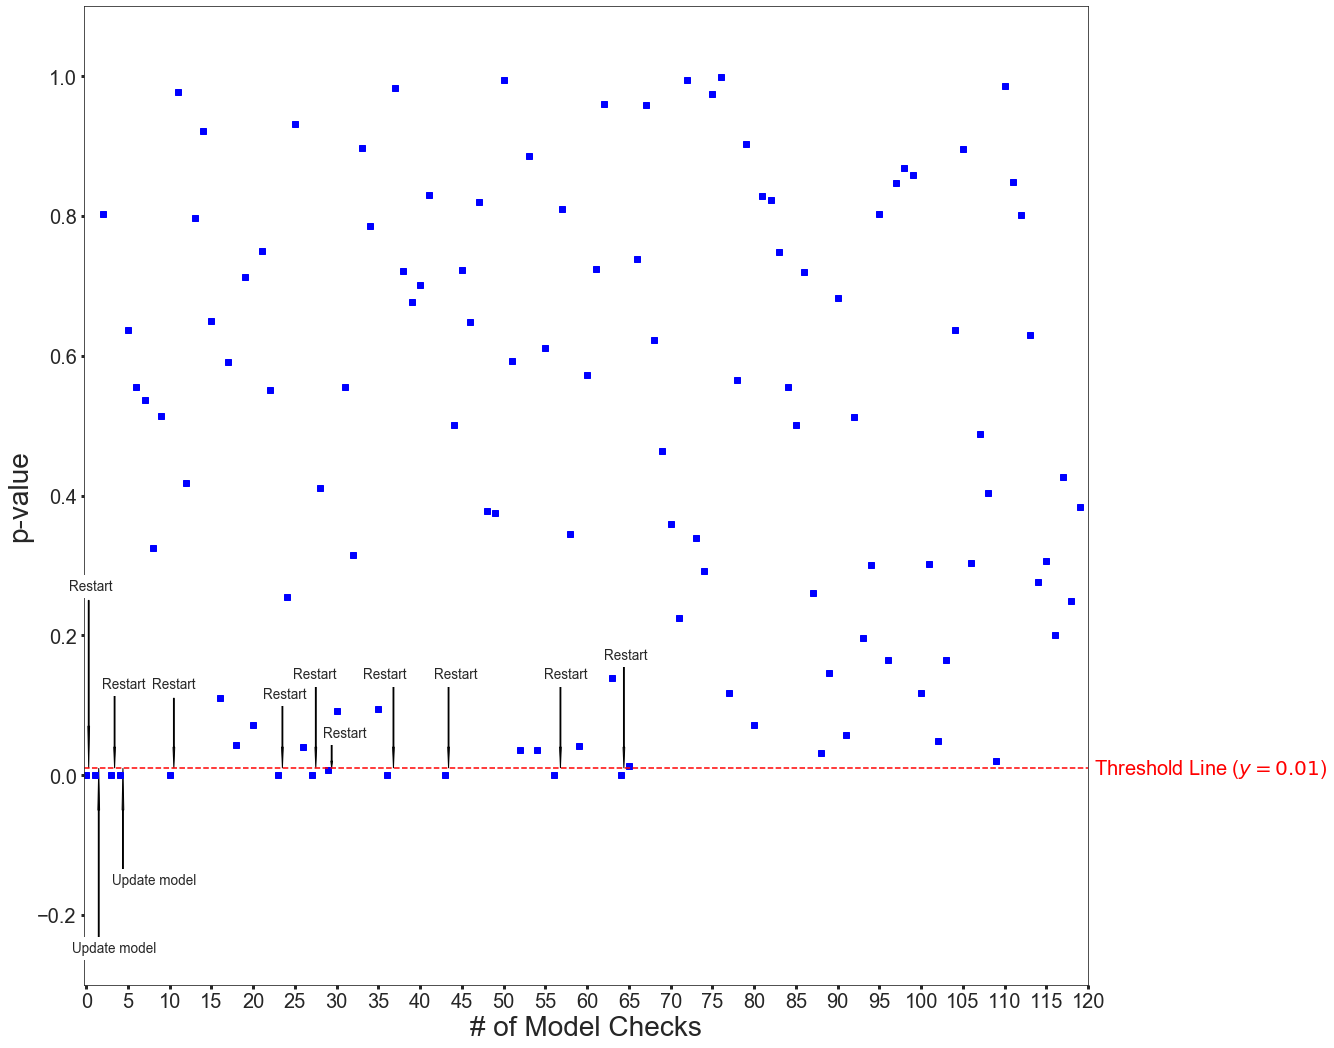

In [122]:
sns.set_style('ticks')
#plt.rcParams["pdf.use14corefonts"] = True
data_fit_vec_plot = 0.5* data_fit_vec.detach()[1:]
entropy_vec_plot = entropy_vec.detach()[1:]
p21_vec_plot = p21_vec.detach()[1:]
f, ax = plt.subplots(1, 1, figsize=(18, 18))
#ax.plot(np.array(range(2,iter+2)), torch.log(entropy_vec_plot), '+-')
#print(p21_vec_plot)
ax.plot(p21_vec_plot,'s',color = 'blue', markersize=6)
ax.axhline(.01,linestyle = '--',color = 'red', markersize=12, alpha = 1.0)
ax.set_xlim(-0.3, p21_vec_plot.shape[0])
ax.set_ylim(-0.3, 1.1)
#ax.set_yscale('log')
plt.xticks(np.arange(0, iter+15, step=5.))
ax.tick_params(labelsize='small', width=3)
ax.set_xlabel('# of Model Checks')
ax.set_ylabel('p-value')
ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.03, 0.03), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(1.5,        #x start point
             -0.25,                      #y start point
             0,       #change in x 
             0.2,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black')             #arrow edge color

ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.007, 0.4), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(0.3,        #x start point
             0.25,                      #y start point
             0,       #change in x 
             -0.18,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 


#############################
ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.07, 0.1), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(4.4,        #x start point
             -0.15,                      #y start point
             0,       #change in x 
             0.1,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black')             #arrow edge color


ax.annotate('Restart', xy=(0.55, 0.15), xytext=(0.04, 0.3), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(3.4,        #x start point
             0.12,                      #y start point
             0,       #change in x 
             -0.08,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.03,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 

###############################################
# ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.14, 0.15), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(9.5,        #x start point
#              -0.09,                      #y start point
#              0,       #change in x 
#              0.07,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.03,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black')             #arrow edge color


ax.annotate('Restart', xy=(0.55, 0.15), xytext=(0.09, 0.3), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(10.5,        #x start point
             0.11,                      #y start point
             0,       #change in x 
             -0.07,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.03,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 

###############################################


ax.annotate('Restart', xy=(0.55, 0.15), xytext=(0.2, 0.29), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(23.5,        #x start point
             0.12,                      #y start point
             0,       #change in x 
             -0.08,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.03,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 
#############################
ax.annotate('Restart', xy=(0.55, 0.15), xytext=(0.23, 0.31), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(27.5,        #x start point
             0.13,                      #y start point
             0,       #change in x 
             -0.09,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.03,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 

#############

# ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.26, 0.03), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(20.2,        #x start point
#              -0.25,                      #y start point
#              0,       #change in x 
#              0.2,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.06,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black')             #arrow edge color



#############################
ax.annotate('Restart', xy=(0.55, 0.15), xytext=(0.26, 0.25), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(29.4,        #x start point
             0.05,                      #y start point
             0,       #change in x 
             -0.03,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.01,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 

#############################
ax.annotate('Restart', xy=(0.55, 0.15), xytext=(0.3, 0.31), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(36.8,        #x start point
             0.13,                      #y start point
             0,       #change in x 
             -0.09,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.03,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 


#############################
ax.annotate('Restart', xy=(0.55, 0.15), xytext=(0.37, 0.31), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(43.4,        #x start point
             0.13,                      #y start point
             0,       #change in x 
             -0.09,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.03,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 
##########
#############################
ax.annotate('Restart', xy=(0.55, 0.15), xytext=(0.48, 0.31), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(56.8,        #x start point
             0.13,                      #y start point
             0,       #change in x 
             -0.09,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.03,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 
##########
ax.annotate('Restart', xy=(0.55, 0.15), xytext=(0.54, 0.33), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(64.4,        #x start point
             0.17,                      #y start point
             0,       #change in x 
             -0.13,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.03,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 


###############################

ax.annotate('Threshold Line ($y = 0.01$)', xy=(1.0,0.01), xytext=(6,0), color='red', 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=14, fontsize = 20, va="center")



#ax.legend(['p-value', 'p-value Threshold ($0.01$)'], loc = 'lower right')
plt.savefig('figures/qvalue_fail_EIBehavior.pdf',dpi=300, bbox_inches='tight')
plt.show()

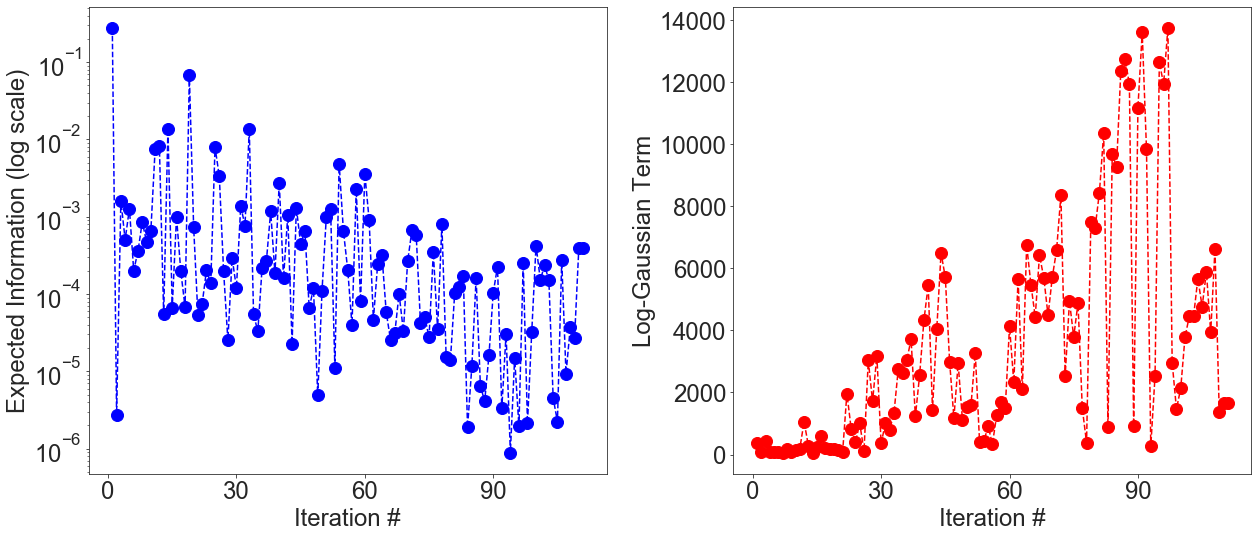

In [123]:
sns.set_style('ticks')
data_fit_vec_plot = 0.5* data_fit_vec.detach()[1:]
entropy_vec_plot = entropy_vec.detach()[1:]
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(18, 8), tight_layout=True)

ax1.plot(np.array(range(1,iter+2)), (entropy_vec_plot), '--o', color = 'blue', markersize=12)
#ax1.set_yscale('log')
# ax.plot(np.array(data_fit_vec_plot), (entropy_vec_plot), 'o')
ax1.set_yscale('log')

ax2.plot(np.array(range(1,iter+2)), data_fit_vec_plot, '--o', color = 'red', markersize=12)

ax1.set_xlabel('Iteration #', size=24)
ax2.set_xlabel('Iteration #', size=24)
ax1.set_xticks(np.arange(0,iter+5, step=30.))
ax1.set_ylabel('Expected Information (log scale)', size = 24)
ax2.set_ylabel('Log-Gaussian Term', size = 24)
ax2.set_xticks(np.arange(0,iter+5, step=30.))
#ax2.yfmt.set_useOffset(10000)

plt.savefig('figures_Carlo/expectedinfo_vs_datafit_fail_EIbehavior.pdf',dpi=300, bbox_inches='tight')
plt.show()

In [17]:
np.savetxt('data_plots/vec_x_fail_EIbehavior.txt',vec_x.detach().numpy())
np.savetxt('data_plots/g_theta2_fail_EIbehavior.txt', g_theta2.detach().numpy())
np.savetxt('data_plots/g_theta1_fail_EIbehavior.txt', g_theta1.detach().numpy())
np.savetxt('data_plots/x_train_ini_fail_EIbehavior.txt', x_train.detach().numpy())
np.savetxt('data_plots/y_train_ini_fail_EIbehavior.txt', y_train.detach().numpy())
np.savetxt('data_plots/agg_data_fail_EIbehavior.txt', agg_data.detach().numpy())
np.savetxt('data_plots/entropy_vec_fail_EIbehavior.txt', entropy_vec_plot.detach().numpy())
np.savetxt('data_plots/datafit_fail_EIbehavior.txt', data_fit_vec_plot.detach().numpy())
np.savetxt('data_plots/p21_vec_fail_EIbehavior.txt',p21_vec_plot.detach().numpy())
np.savetxt('data_plots/loss_fail_EIbehavior.txt',loss.detach().numpy())
np.savetxt('data_plots/pf1_fail_EIbehavior.txt',pf1.detach().numpy())
np.savetxt('data_plots/Qf1_fail_EIbehavior.txt',Qf1.evaluate().detach().numpy())
np.savetxt('data_plots/Qf12_fail_EIbehavior.txt', Qf12.evaluate().detach().numpy())
np.savetxt( 'data_plots/Q21_fail_EIbehavior.txt', Q21.evaluate().detach().numpy())
#np.savetxt('data_plots/iter_fail_EIbehavior.txt', iter+1)

ValueError: Expected 1D or 2D array, got 0D array instead

In [18]:
v2 = g_theta2_vec.reshape(math.ceil(g_theta2_vec.shape[0]/2),2)


In [19]:
np.savetxt('data_plots/v2_fail_EIbehavior.txt', v2.detach().numpy())

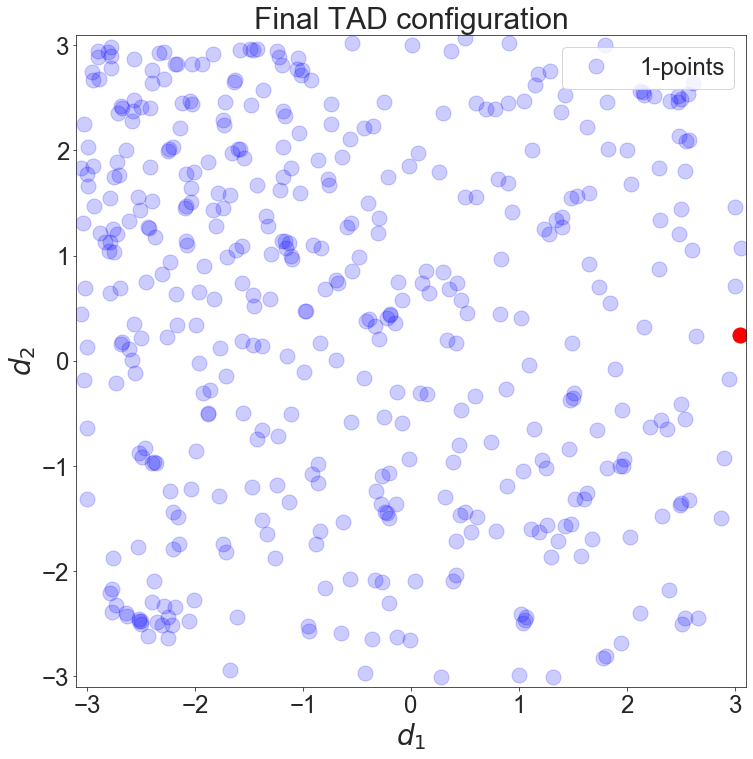

In [21]:
fig, ax = plt.subplots(figsize = (12,12))
ax.set_xlim(-3.1, 3.1)
ax.set_ylim(-3.1, 3.1)
#ax.scatter(g_theta1[:, 0].detach(),g_theta1[:, 1].detach(), c="b", alpha=0.8)
ax.plot(g_theta1[:, 0].detach(),g_theta1[:, 1].detach() , 'o', color = 'blue',markersize=15, alpha = 0.2)
ax.plot(vec_x[-1,0], vec_x[-1,1],'o', color = 'red',markersize=15)
#ax.plot(0.8731, 0.5664,'go', color = 'green',markersize=15)
ax.set_title('Final TAD configuration')
ax.set_xlabel('$d_1$')
ax.set_ylabel('$d_2$')
ax.legend(['1-points'])
plt.savefig('figures/tad_sol_allpoints_fail_EIbehavior.pdf')
plt.show()

In [22]:
import matplotlib.ticker
class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
             self.format = r'$\mathdefault{%s}$' % self.format

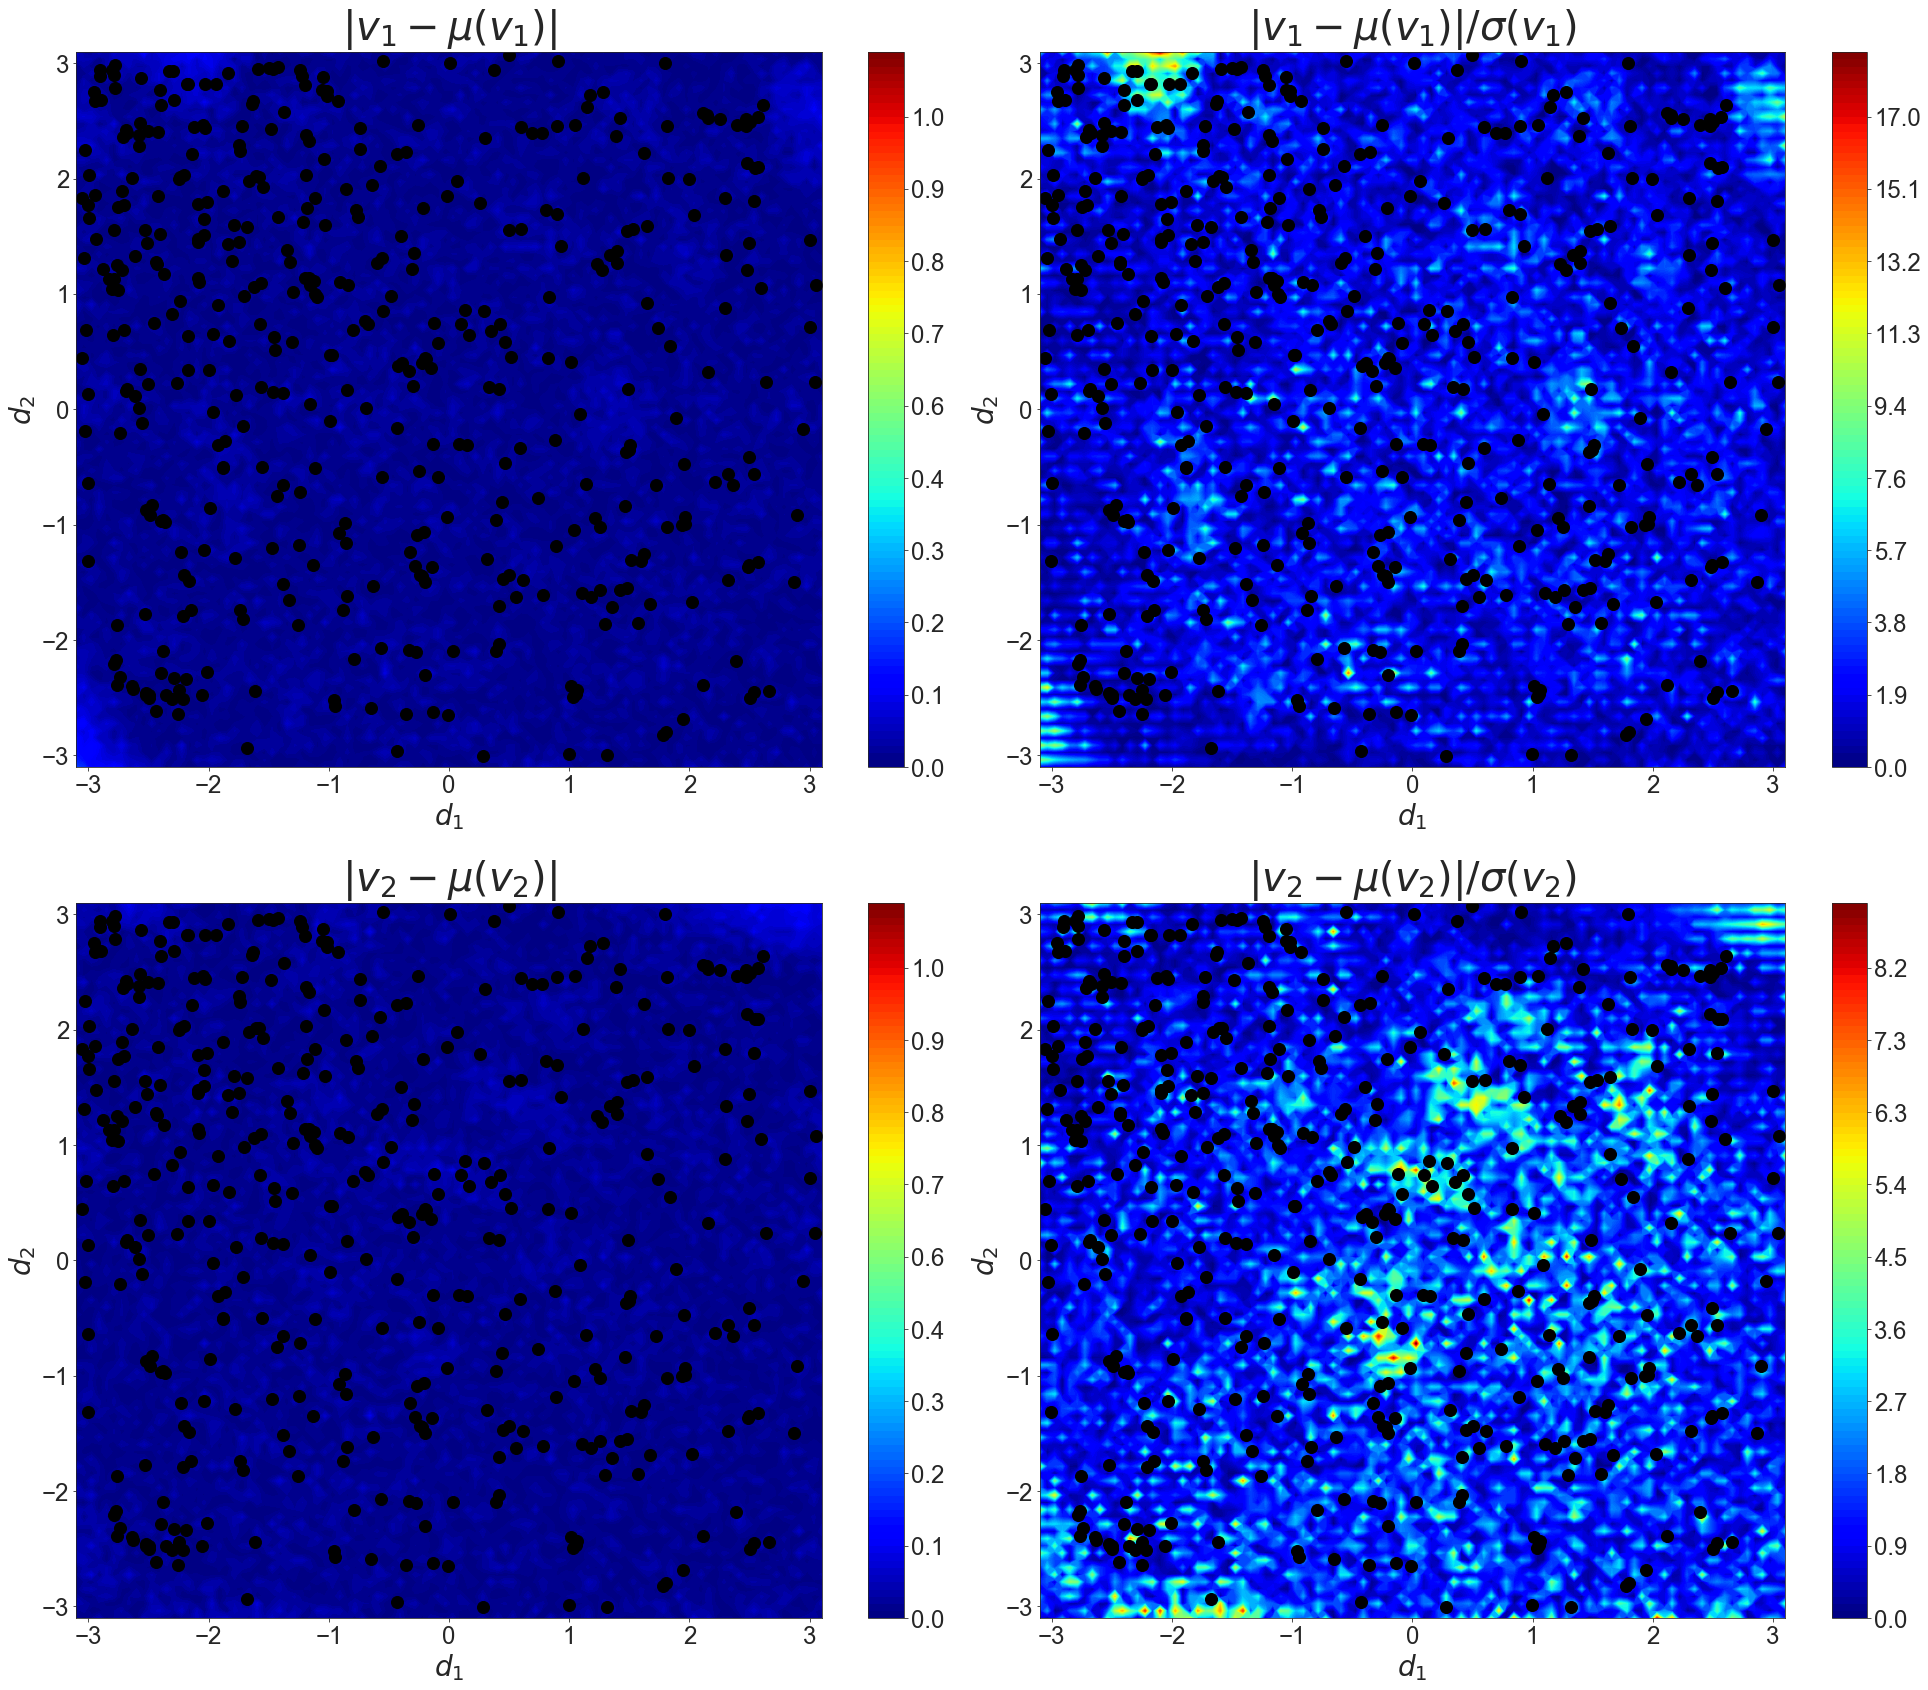

In [124]:
f_target = vf.tgt_vec
f_target = f_target.reshape(f_target.shape[0],1)
vf.tgt_loc = vf.tgt_loc.reshape(2,1)
#x0 = Tensor(np.array([0.1937, 0.1257]))
#x0 = Tensor(np.array([0.1885, 0.1038]))
x_plot = np.linspace(-3.1, 3.1, 100)
y_plot = np.linspace(-3.1, 3.1, 100)
xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
n = x_plot.shape[0]
x_concat_ = torch.zeros(n * n, 2)

# n_sample = x_concat_.shape[0]
num_tasks = 2
i = 0
k = 0
while i < n*n:
    x_concat_[i:i+n,0] = Tensor(xv_plot[:,k])
    x_concat_[i:i+n,1] = Tensor(y_plot)
    k = k+1
    i = i+n
    

tgt_plot = vfield_(x_concat_)



v_1 = tgt_plot[:,0].reshape(n,n)
v_2 = tgt_plot[:,1].reshape(n,n)

model.eval()

likelihood.eval()

#noise = torch.eye(2 * g_theta1.detach().shape[0]) * noise_value
#print(x_concat_)
with torch.no_grad(), gpytorch.settings.fast_pred_var(True):
    pred = GPprediction(model)
    pr_mean, cov = pred.GPpred(g_theta1.detach(), agg_data, x_concat_, noise_value)
    #pr = (model(g_theta1.detach())) # likelihood(model(x_concat_), noise = torch.ones(x_concat_.shape) * noise_value)#
    pr_mean = pr_mean.reshape(x_concat_.shape[0], num_tasks)
    mean_v_1 = pr_mean[:,0].reshape(n,n)
    mean_v_2 = pr_mean[:,1].reshape(n,n)
    pred_var = cov.diag().reshape(num_tasks, x_concat_.shape[0]).T
    
    var_v_1 = pred_var[:,0].reshape(n,n)
    var_v_2 = pred_var[:,1].reshape(n,n)
#     AA = pr.covariance_matrix.mean(axis=0).reshape(num_tasks, x_concat_.shape[0]).T #.diag() #.reshape(num_tasks, num_tasks * g_theta1.shape[0]).T

# #     print(pr.covariance_matrix.mean(axis=0))
# #     print(AA)
# #     print(pr.variance)
# #     print((pr.covariance_matrix))
# #     K = model.covar_module
#     print((cov.diag()))
#     print(pr_mean)


fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (28, 24), tight_layout=True)
diff_mean_v1= torch.abs(v_1 - mean_v_1.detach())#/torch.abs(v_1)
cs10 = ax1[0].contourf(xv_plot, yv_plot,diff_mean_v1 ,np.linspace(0, 1.1, 100), cmap = 'jet')
#ax1[0].plot(vf.tgt_loc[0],vf.tgt_loc[1], 'o', color = 'magenta', markersize=12)
ax1[0].plot(g_theta1[:, 0].detach(),g_theta1[:, 1].detach() , 'o', color = 'black',markersize=12, alpha = 1.0)
ax1[0].set_title('$|v_1 - \mu(v_1)|$', fontsize = 40)
cbar10 = fig.colorbar(cs10, ax = ax1[0],format=OOMFormatter(0, mathText=False));

ax1[0].set_xlabel('$d_1$')
ax1[0].set_ylabel('$d_2$')
diff_mean_v1 = torch.abs(v_1 - mean_v_1.detach())/torch.sqrt(var_v_1)
#print(var_v_1)
cs11 = ax1[1].contourf(xv_plot, yv_plot,diff_mean_v1 ,np.linspace(diff_mean_v1.min(), diff_mean_v1.max(), 100), cmap = 'jet')
#ax1[1].plot(vf.tgt_loc[0],vf.tgt_loc[1], 'o', color = 'magenta', markersize=12)
ax1[1].plot(g_theta1[:, 0].detach(),g_theta1[:, 1].detach() , 'o', color = 'black',markersize=12, alpha = 1.0)
ax1[1].set_title('$|v_1 - \mu(v_1)|/\sigma(v_1)$', fontsize = 40)
# ax1[0].set_aspect('equal')
# ax1[1].set_aspect('equal')
cbar11 = fig.colorbar(cs11, ax = ax1[1],format=OOMFormatter(0, mathText=False));
ax1[1].set_xlabel('$d_1$')
ax1[1].set_ylabel('$d_2$')


diff_mean_v2= torch.abs(v_2 - mean_v_2.detach())
cs20 = ax2[0].contourf(xv_plot, yv_plot, diff_mean_v2,np.linspace(0, 1.1, 100), cmap = 'jet')
#ax2[0].plot(vf.tgt_loc[0],vf.tgt_loc[1], 'o', color = 'magenta', markersize=12)
ax2[0].plot(g_theta1[:, 0].detach(),g_theta1[:, 1].detach() , 'o', color = 'black',markersize=12, alpha = 1.0)
ax2[0].set_title('$|v_2 - \mu(v_2)|$', fontsize = 40)
cbar20 = fig.colorbar(cs20, ax = ax2[0],format=OOMFormatter(0, mathText=False));
ax2[0].set_xlabel('$d_1$')
ax2[0].set_ylabel('$d_2$')


diff_mean_v2= torch.abs(v_2 - mean_v_2.detach())/torch.sqrt(var_v_2)
cs21 = ax2[1].contourf(xv_plot, yv_plot, diff_mean_v2,np.linspace(diff_mean_v2.min(), diff_mean_v2.max(), 100), cmap = 'jet')
ax2[1].plot(g_theta1[:, 0].detach(),g_theta1[:, 1].detach() , 'o', color = 'black',markersize=12, alpha = 1.0)
#ax2[1].plot(vf.tgt_loc[0],vf.tgt_loc[1], 'o', color = 'magenta', markersize=12)
ax2[1].set_title('$|v_2 - \mu(v_2)|/\sigma(v_2)$', fontsize = 40)
cbar21 = fig.colorbar(cs21, ax = ax2[1],format=OOMFormatter(0, mathText=False));
ax2[1].set_xlabel('$d_1$')
ax2[1].set_ylabel('$d_2$')


# ax2[0].set_aspect('equal')
# ax2[1].set_aspect('equal')

plt.savefig('figures_Carlo/mean_var/mean_final__fail_2_EIBehavior.pdf', dpi=300, bbox_inches='tight')
plt.show()




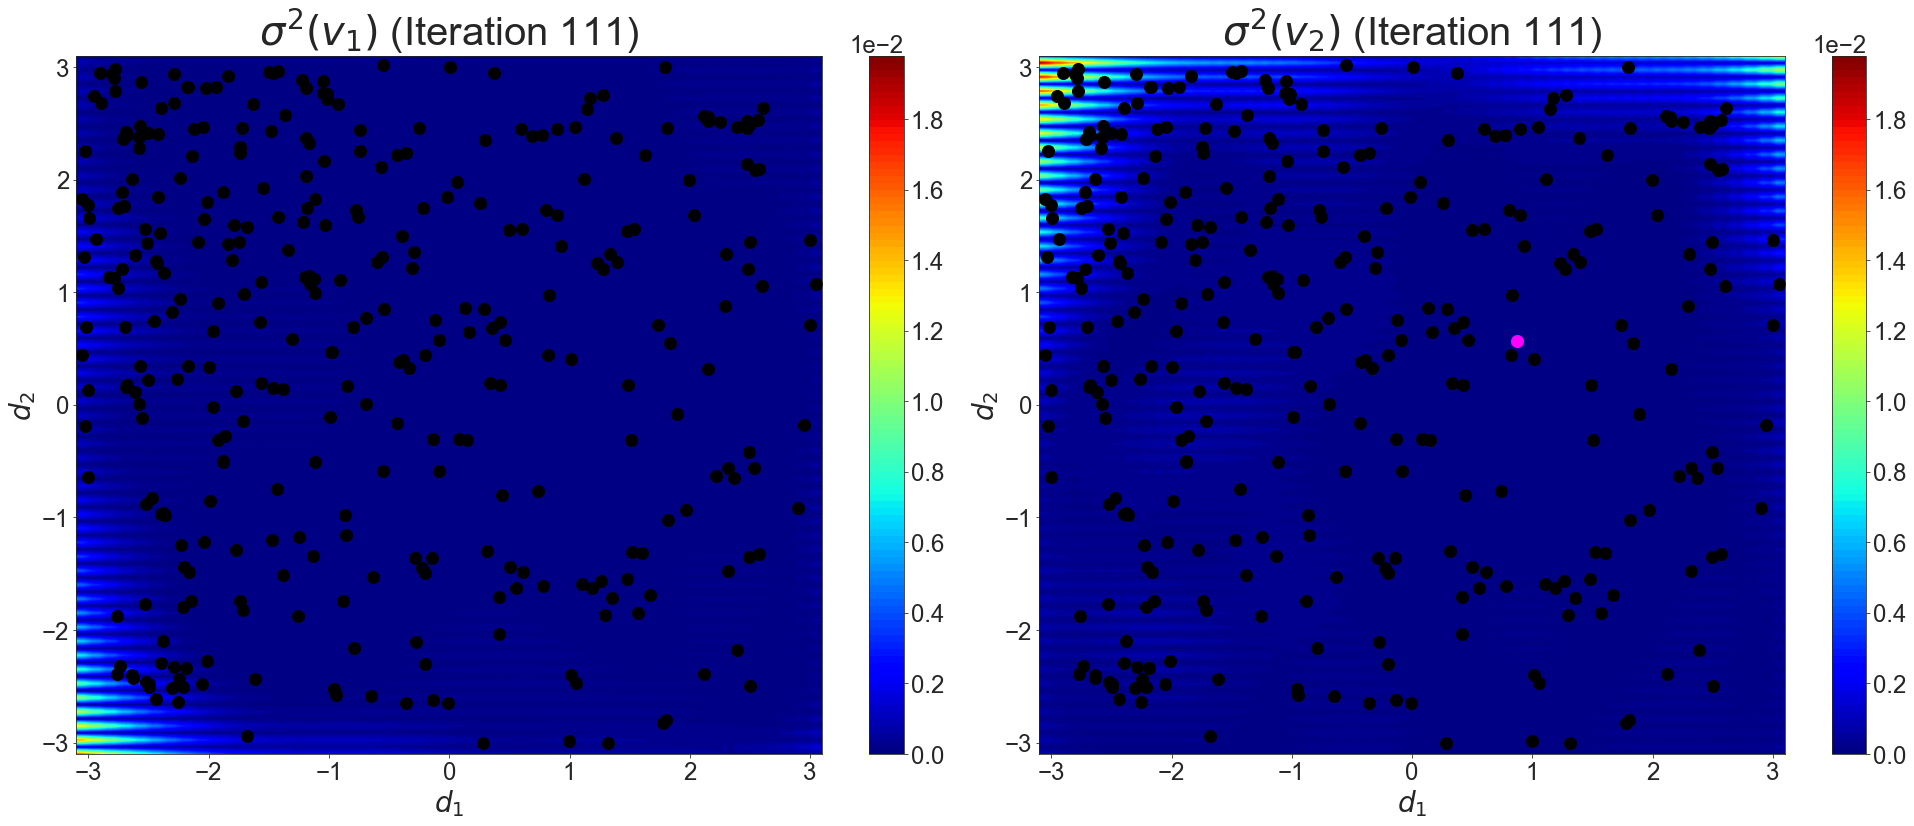

In [43]:
f_target = vf.tgt_vec
f_target = f_target.reshape(f_target.shape[0],1)
vf.tgt_loc = vf.tgt_loc.reshape(2,1)
#x0 = Tensor(np.array([0.1937, 0.1257]))
#x0 = Tensor(np.array([0.1885, 0.1038]))
x_plot = np.linspace(-3.1, 3.1, 100)
y_plot = np.linspace(-3.1, 3.1, 100)
xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
n = x_plot.shape[0]
x_concat_ = torch.zeros(n * n, 2)

# n_sample = x_concat_.shape[0]
num_tasks = 2
i = 0
k = 0
while i < n*n:
    x_concat_[i:i+n,0] = Tensor(xv_plot[:,k])
    x_concat_[i:i+n,1] = Tensor(y_plot)
    k = k+1
    i = i+n
    

tgt_plot = vfield_(x_concat_)



v_1 = tgt_plot[:,0].reshape(n,n)
v_2 = tgt_plot[:,1].reshape(n,n)
plot = [iter+1]

for ii in plot:
    try:
        
        PATH = ".//model_Carlo/model_goodmodel/model_fail_EIbehavior_"+str(ii - 1)+".pt"
        model_16 = torch.load(PATH)
    except:
        PATH = ".//model_Carlo/model_update/model_fail_EIbehavior_"+str(ii - 1)+".pt"
        model_16 = torch.load(PATH)
        
    #model_16 = torch.load(PATH)
    model_16.eval()

    likelihood.eval()

    #noise = torch.eye(2 * g_theta1.detach().shape[0]) * noise_value
    #print(x_concat_)
    with torch.no_grad(), gpytorch.settings.fast_pred_var(False):
        pred = GPprediction(model_16)
        pr_mean, cov = pred.GPpred(g_theta1.detach(), agg_data, x_concat_, noise_value)
        #pr = (model(g_theta1.detach())) # likelihood(model(x_concat_), noise = torch.ones(x_concat_.shape) * noise_value)#
        pr_mean = pr_mean.reshape(x_concat_.shape[0], num_tasks)
        mean_v_1 = pr_mean[:,0].reshape(n,n)
        mean_v_2 = pr_mean[:,1].reshape(n,n)
        pred_var = cov.diag().reshape(num_tasks, x_concat_.shape[0]).T

        var_v_1 = pred_var[:,0].reshape(n,n)
        var_v_2 = pred_var[:,1].reshape(n,n)
    #     AA = pr.covariance_matrix.mean(axis=0).reshape(num_tasks, x_concat_.shape[0]).T #.diag() #.reshape(num_tasks, num_tasks * g_theta1.shape[0]).T

    # #     print(pr.covariance_matrix.mean(axis=0))
    # #     print(AA)
    # #     print(pr.variance)
    # #     print((pr.covariance_matrix))
    # #     K = model.covar_module
    #     print((cov.diag()))
    #     print(pr_mean)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (28, 12), tight_layout=True)
    diff_mean_v1= torch.abs(v_1 - mean_v_1.detach())#/torch.abs(v_1)
    minn = torch.min(var_v_1.detach().min(), var_v_2.detach().min())
    maxx = torch.min(var_v_1.detach().max(), var_v_2.detach().max())

    cs11 = ax1.contourf(xv_plot, yv_plot, var_v_1.detach(), np.linspace(0.0, .02, 100), cmap = 'jet')
   # ax1.plot(vf.tgt_loc[0],vf.tgt_loc[1], 'o', color = 'magenta', markersize=12)
    
    ax1.plot(g_theta1[0:(4 + (ii - 1)* 3), 0].detach(),g_theta1[0:(4 + (ii - 1)* 3), 1].detach() , 'o', color = 'black',markersize=12, alpha = 1.0)
  
    ax1.set_title('$\sigma^2(v_1)$ (Iteration '+str(ii)+')', fontsize = 40)
    # ax1[0].set_aspect('equal')
    # ax1[1].set_aspect('equal')
    cbar11 = fig.colorbar(cs11, ax = ax1,format=OOMFormatter(-2, mathText=False));
    ax1.set_xlabel('$d_1$')
    ax1.set_ylabel('$d_2$')


  


    cs21 = ax2.contourf(xv_plot, yv_plot, var_v_2.detach(), np.linspace(0.0, .02, 100), cmap = 'jet')
    ax2.plot(g_theta1[0:(4 + (ii - 1)* 3), 0].detach(),g_theta1[0:(4 + (ii - 1)* 3), 1].detach() , 'o', color = 'black',markersize=12, alpha = 1.0)
    ax2.plot(vf.tgt_loc[0],vf.tgt_loc[1], 'o', color = 'magenta', markersize=12)
    ax2.set_title('$\sigma^2(v_2)$ (Iteration '+str(ii)+')', fontsize = 40)
    cbar21 = fig.colorbar(cs21, ax = ax2,format=OOMFormatter(-2, mathText=False));
    ax2.set_xlabel('$d_1$')
    ax2.set_ylabel('$d_2$')


    # ax2[0].set_aspect('equal')
    # ax2[1].set_aspect('equal')

    plt.savefig('figures_Carlo/mean_var/var_iter_fail_EIBehavior'+str(ii)+'.pdf', dpi=300, bbox_inches='tight')
    plt.show()





In [25]:
# x_plot = np.linspace(-3.1, 3.1, 30)
# y_plot = np.linspace(-3.1, 3.1, 30)
# xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
# n = x_plot.shape[0]
# x_concat_ = torch.zeros(n * n, 2)
# training_param_iter = 200

# # n_sample = x_concat_.shape[0]
# num_tasks = 2
# i = 0
# k = 0
# while i < n*n:
#     x_concat_[i:i+n,0] = Tensor(xv_plot[:,k])
#     x_concat_[i:i+n,1] = Tensor(y_plot)
#     k = k+1
#     i = i+n

# #dis_2sample = MultivariateNormal( loc = x0, covariance_matrix= .01 * torch.eye(2) )
#                     #loc_size = 4
# loc_sample = 1./3. * Tensor(high_minus_low  * np.random.random_sample((3,2)) + vf.low) # #dis_2sample.sample((2 + 1,))
# loc_sample0 = loc_sample.reshape(2 + 1, 2)
# g2 = g_theta2.detach() #loc_sample0 #Tensor(loc_sample) #.detach()
# likelihood.eval()
# model.eval()
# plot = [1, 6, 12, 17, 30, 35, 38, 56, 76]
# zz = torch.zeros(n*n, 9)
# kk = 0
# for jj in plot:
#     try:
        
#         PATH = ".//model_Carlo/model_goodmodel/model_fail_"+str(jj - 1)+".pt"
#         model_16 = torch.load(PATH)
#     except:
#         PATH = ".//model_Carlo/model_update/model_fail_"+str(jj - 1)+".pt"
#         model_16 = torch.load(PATH)
#    # model_16 = torch.load(PATH)
#     model_16.eval()

#     likelihood.eval()
#     g2 = v2.detach()[jj - 1 +loc_size+1 : jj - 1 +loc_size+1 +loc_size+1]
#     g_theta1_cur = g_theta1[0:(4 + (jj - 1)* 3)]
#     agg_data_cur = agg_data[0:2 * (4 + (jj - 1)* 3)]
#     print(agg_data_cur.shape)
#     for ii in range(n*n):
#         print(ii)
#         x0 = x_concat_[ii,:].reshape(1,2)
#     #     dis_2sample = MultivariateNormal( loc = x0, covariance_matrix= .001 * torch.eye(2) )
#     #                     #loc_size = 4
#     #     loc_sample = dis_2sample.sample((2 + 1,))
#     #     loc_sample0 = loc_sample.reshape(2 + 1, 2)
#         #g2 = loc_sample0 #Tensor(loc_sample) #.detach()


        
#         loss2_, pf1_, Qf1_, Qf12_, data_fit_, Q21_ = likelihood.get_ell(agg_data_cur,f_target,x0, g_theta1_cur, model_16, likelihood, noise_value, g2)
#         zz[ii, kk] = loss2_
#     kk = kk+1
# zz = zz.reshape(n,n, 9)
# torch.save(zz, 'data_plots/zz_fail.txt')

In [26]:
# import matplotlib.ticker
# class OOMFormatter(matplotlib.ticker.ScalarFormatter):
#     def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
#         self.oom = order
#         self.fformat = fformat
#         matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
#     def _set_order_of_magnitude(self):
#         self.orderOfMagnitude = self.oom
#     def _set_format(self, vmin=None, vmax=None):
#         self.format = self.fformat
#         if self._useMathText:
#              self.format = r'$\mathdefault{%s}$' % self.format

In [27]:
# for jj in range(9):
#     fig, ax = plt.subplots(figsize = (16,14))
#     #
#     cs = ax.contour(xv_plot, yv_plot,  zz[:,:,jj].detach(), np.linspace( zz[:,:,jj].detach().numpy().min(), zz[:,:,jj].detach().numpy().max(), 1000), cmap = 'jet')
#     cbar = fig.colorbar(cs, ax = ax,format=OOMFormatter(0, mathText=False));
#     #ax.plot(vf.tgt_loc[0,0],vf.tgt_loc[0,1], 'o', color = 'magenta', markersize=12)
#     kk = plot[jj]
#     if kk < plot[8]:
#         ax.plot(vec_x[kk,0], vec_x[kk,1],'o', color = 'black',markersize=12)
#     if kk == plot[8]:
#         ax.plot(vec_x[- 1,0], vec_x[- 1,1],'o', color = 'black',markersize=12)
#     ax.set_title('TAD Acquisition Function (Iteration '+str(kk)+')', fontsize = 40)
#     ax.set_xlabel('$d_1$')
#     ax.set_ylabel('$d_2$')
    
    
#     plt.savefig('figures_Carlo/tad_obj_fail'+str(kk)+'.pdf', dpi=300, bbox_inches='tight')

## 

In [28]:
vec_x

tensor([[-2.0000, -2.0000],
        [-0.0626,  1.2176],
        [ 0.5970,  2.4483],
        [-1.0285,  2.9942],
        [-1.4818,  2.4275],
        [-0.5966,  1.2698],
        [-1.7730,  0.1198],
        [-2.7893,  1.1271],
        [-2.9996,  1.7729],
        [-3.0005, -0.6390],
        [-2.5678,  0.3458],
        [-3.0045,  0.1358],
        [-2.4220,  1.8467],
        [-0.3563,  2.2341],
        [ 0.0098,  2.9999],
        [ 1.7926,  3.0012],
        [-1.1131,  1.8312],
        [ 0.3349,  0.1953],
        [-0.8639, -0.9818],
        [-0.0879, -0.5894],
        [ 0.4151, -2.0342],
        [ 1.3167, -3.0004],
        [-1.8843,  1.8933],
        [-1.1956,  1.1354],
        [ 0.4960,  1.5528],
        [ 1.6245,  2.2190],
        [ 3.0006,  0.7108],
        [-2.1385,  2.2123],
        [-0.0156,  1.8475],
        [ 1.1171,  2.0083],
        [ 3.0019,  1.4663],
        [-3.0285,  2.2511],
        [-3.0191,  0.6892],
        [-3.0381,  1.3134],
        [-3.0544,  1.8312],
        [-1.4258,  1

In [ ]:
print(g_theta2)

In [ ]:
vec_x = vec_x.detach()
#v2 = g_theta2_vec.reshape(math.ceil(g_theta2_vec.shape[0]/2), 2)
ii = 0
low = -3.2
high = 3.2
########################
f, ax = plt.subplots(1, 1, figsize=(14, 14))
ax.plot(0.8731, 0.5664,'d', color = 'green',markersize=15)
ax.plot(vec_x[ii,0], vec_x[ii,1],'v', color = 'red',markersize=15)
ax.plot(x_train.detach()[:,0], x_train.detach()[:,1], 's', color = 'black', markersize=15, alpha = 0.2)
ax.plot(loc_sample0.detach()[ii:ii+loc_size+1,0], loc_sample0.detach()[ii:ii+loc_size+1,1], 'o', color = 'blue', markersize=15)
ax.set_xlabel('$d_1$')
ax.set_ylabel('$d_2$')
ax.set_title('Initial Configuration', fontsize = 40)
ax.legend(['Target', 'Initial Target Candidate', 'Initial 1-sample','Initial 2-sample'])

ax.set_xlim(low, high)
ax.set_ylim(low, high)
plt.savefig('figures_Carlo/evol_solTAD/evol_sol_ini_2_EI_behavior.pdf')

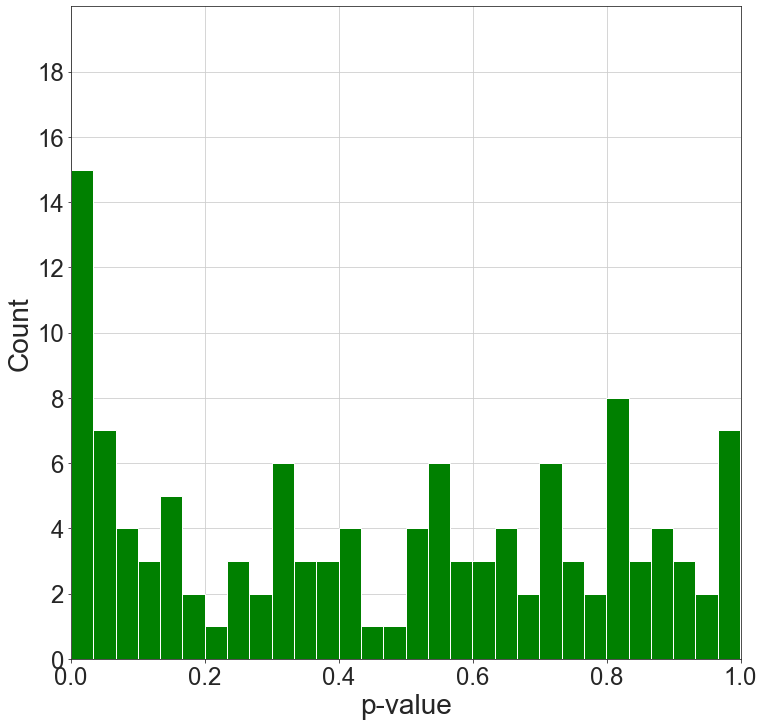

In [37]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize = (12,12))

#data= scipy.io.loadmat('data_plots/p_vec_fail.mat')
#p_fail =p_vec_plot
count, bins, ignored = ax.hist(p21_vec_plot.detach().numpy(), 30, facecolor='green') 

ax.set_xlabel('p-value')
ax.set_ylabel('Count')
#plt.title("Uniform Distribution Histogram (Bin size 20)")
ax.set_xlim(0, 1)
ax.set_ylim(0, 20)
plt.xticks(np.arange(0, 1.2, step=.2))
plt.yticks(np.arange(0, 20, step=2.))
#ax.set_axis([0, 1, 0, 20]) # x_start, x_end, y_start, y_end
ax.grid(True)


plt.savefig('figures_Carlo/p_value_fail_hist_EI.pdf', dpi=300, bbox_inches='tight')
plt.show(block = False)

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize = (14,12))

#data= scipy.io.loadmat('data_plots/p_vec_fail.mat')
#p_fail =p_vec_plot
count, bins, ignored = ax.hist(p21_vec_plot.detach().numpy()[9:], 15, facecolor='green') 

ax.set_xlabel('p-value')
ax.set_ylabel('Count')
#plt.title("Uniform Distribution Histogram (Bin size 20)")
ax.set_xlim(0, 1)
ax.set_ylim(0, 12)
plt.xticks(np.arange(0, 1.2, step=.2))
plt.yticks(np.arange(0, 12, step=2.))
#ax.set_axis([0, 1, 0, 20]) # x_start, x_end, y_start, y_end
ax.grid(True)


plt.savefig('figures_Carlo/p_value_fail_hist_EI.pdf', dpi=300, bbox_inches='tight')
plt.show(block = False)

In [ ]:
p21_vec_plot